In [1]:
from keras.layers import *
import os
from keras.applications import resnet50, vgg16
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Input
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
model = vgg16.VGG16(weights='imagenet')

dic = {}

In [3]:
def build_model(model):
    print(model.summary())
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print(model.summary())
    return model

In [4]:
model = build_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [301]:
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
import tqdm
def findFeatures(files, model, path):
    dic = {}
    i = 0
    files = os.listdir(path)
    for file in tqdm.tqdm_notebook(files):
        img = image.load_img(path+file, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        features = model.predict(img)
        dic[file] = features
    return dic

In [6]:
from pickle import dump, load

In [ ]:

feature_dic = findFeatures(files, model, './Flicker8k_Dataset/')
dump(feature_dic, open('img_features.pkl', 'wb'))

In [12]:
feature_dic = load(open('img_features.pkl', 'rb'))

In [13]:
for v, x in feature_dic.items():
    print(v, x.shape)
    break

1000268201_693b08cb0e.jpg (1, 4096)


Number of all Imgs 8000
Number of training Imgs 6000
Number of Validation Imgs 1000
Number of Test Imgs 1000


('\tA man do a jump trick on a bike .\n', '2914800692_0c512d27b8.jpg')

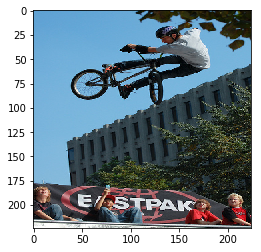

In [88]:
path = './Flickr8k_text/Flickr_8k.trainImages.txt'
import matplotlib.pyplot as plt
def findImgs(path):
    f = open(path, 'r')
    dataset = []
    lines = f.readlines()
    for line in lines:
        line = line[:-1]
        dataset.append(line)
    
    return list(set(dataset))

trainImgs = findImgs('./Flickr8k_text/Flickr_8k.trainImages.txt')
validImgs = findImgs('./Flickr8k_text/Flickr_8k.devImages.txt')
testImgs = findImgs('./Flickr8k_text/Flickr_8k.testImages.txt')
allImgs = list(set(trainImgs + validImgs + testImgs))
all_size = len(allImgs)
train_size = len(trainImgs)
valid_size = len(validImgs)
test_size = len(testImgs)
print("Number of all Imgs {}".format(all_size))
print("Number of training Imgs {}".format(train_size))
print("Number of Validation Imgs {}".format(valid_size))
print("Number of Test Imgs {}".format(test_size))

path = './Flickr8k_text/Flickr8k.lemma.token.txt'
def getDescriptions(path, Imgs):
    i = 0
    f = open(path, 'r')
    lines = f.readlines()
    dataset = []
    img_dataset = []
    for line in lines:
        line = line.split('#')
        img, desc = line[0], line[1][1:]
        i += 1
#         if i == 2:
#             break
#         print(img, desc)
        if img not in Imgs:
            continue
        dataset.append(desc)
        dic[desc] = img
        img_dataset.append(img)

    return dataset, dic, img_dataset

all_descriptions, all_descriptions_dic, all_img_dataset = getDescriptions(path, allImgs)
i = 1001
img = image.load_img('./Flicker8k_Dataset/'+ all_img_dataset[i], target_size=(224, 224))
x = image.img_to_array(img)
plt.imshow(x/255.)
# plt.imshow()
all_descriptions[i], all_img_dataset[i]

In [19]:
def trimWords(tweets):
    for t in range(0, len(tweets)):
        words = tweets[t].split()
        res = []
        for word in words:
            res.append(word.lower())
        tweets[t] = ' '.join(res)

    return tweets

def trimPunctuations(tweets):
    for t in range(0, len(tweets)):
        words = tweets[t].split()
        res = []
        for word in words:
            word = removePunctuations(word)
            res.append(word.lower())
        tweets[t] = ' '.join(res)

    return tweets

def removePunctuations(tweet):
    global table
    tweet = tweet.translate(table)
    return tweet

def convertInput(tweets):
    vocab_to_int = {}
    int_to_vocab = {}
    max_len = -1
    num = 3
    final_res = []
    vocab_to_int["<start>"], int_to_vocab[1] = 1, "<start>"
    vocab_to_int["<end>"], int_to_vocab[2] = 2, "<end>"
    for t in range(0, len(tweets)):
        words = tweets[t].split()
        max_len = max(max_len, len(words)+2)
        res = []
        res.append("<start>")
        for word in words:
            word = removePunctuations(word)
            if word not in vocab_to_int:
                vocab_to_int[word] = num
                int_to_vocab[num] = word
                num += 1
            res.append(word.lower())
        res.append("<end>")
        final_res.append(res)

    return final_res, vocab_to_int, int_to_vocab, max_len

def make_numbers(descriptions, vocab_to_int, max_len):
    final_res = []
    for description in descriptions:
        res = []
        for word in description:
            res.append(vocab_to_int[word])
        final_res.append(res)
    return final_res

In [25]:
import string
import tqdm
table = str.maketrans('', '', string.punctuation)

In [21]:
def prepareData(descriptions, img_dataset):
    descriptions = trimPunctuations(descriptions)
    descriptions = trimWords(descriptions)
    descriptions, vocab_to_int, int_to_vocab, max_len = convertInput(descriptions)
    descriptions = make_numbers(descriptions, vocab_to_int, max_len)
    descriptions = list(zip(img_dataset, descriptions))
    return descriptions, max_len, vocab_to_int, int_to_vocab, len(vocab_to_int) + 1

# train_descriptions, train_max_len = prepareData(train_descriptions, train_img_dataset)
# valid_descriptions, valid_max_len = prepareData(valid_descriptions, valid_img_dataset)
# test_descriptions, test_max_len = prepareData(test_descriptions, test_img_dataset)
all_descriptions, max_len, vocab_to_int, int_to_vocab, corpus_size = prepareData(all_descriptions, all_img_dataset)
train_descriptions = all_descriptions[:train_size]
valid_descriptions = all_descriptions[train_size:(train_size+valid_size)]
test_descriptions = all_descriptions[(train_size+valid_size):(train_size+valid_size+test_size)]
print("Maximum length of a description is {}".format(max_len))
print("Vocabulary Size {}".format(corpus_size))

Maximum length of a description is 34
Vocabulary Size 6643


In [26]:
def makeinput(descriptions, max_len, corpus_size, feature_dic):
    img_features, rnn_input, rnn_output = [], [], []
    for img, description in tqdm.tqdm_notebook(descriptions):
        for i in range(1, len(description)):
            input_desc, output_desc = description[:i], description[i]
            input_desc = input_desc + [0] * (max_len - len(input_desc))
            output_desc = to_categorical([output_desc], num_classes=corpus_size)[0]
            img_features.append(feature_dic[img])
            rnn_input.append(input_desc)
            rnn_output.append(output_desc)
    return img_features, rnn_input, rnn_output

In [27]:
def finalPrep(descriptions, max_len, corpus_size, feature_dic):
    img_features, rnn_input, rnn_output = makeinput(descriptions, max_len, corpus_size, feature_dic)
    img_features, rnn_input, rnn_output = np.array(img_features), np.array(rnn_input), np.array(rnn_output)
    return img_features, rnn_input, rnn_output

In [28]:
train_img_features, train_rnn_input, train_rnn_output = finalPrep(train_descriptions, max_len, corpus_size, feature_dic)
valid_img_features, valid_rnn_input, valid_rnn_output = finalPrep(valid_descriptions, max_len, corpus_size, feature_dic)
test_img_features, test_rnn_input, test_rnn_output = finalPrep(test_descriptions, max_len, corpus_size, feature_dic)

In [64]:
import numpy as np
train_img_features = np.reshape(train_img_features, (train_img_features.shape[0], 4096))
print(train_img_features.shape, train_rnn_input.shape, train_rnn_output.shape)
valid_img_features = np.reshape(valid_img_features, (valid_img_features.shape[0], 4096))
print(valid_img_features.shape, valid_rnn_input.shape, valid_rnn_output.shape)
test_img_features = np.reshape(test_img_features, (test_img_features.shape[0], 4096))
print(test_img_features.shape, test_rnn_input.shape, test_rnn_output.shape)

(57752, 4096) (57752, 34) (57752, 6643)
(9696, 4096) (9696, 34) (9696, 6643)
(9806, 4096) (9806, 34) (9806, 6643)


In [65]:
!pip3 install pydot

In [66]:
from keras.utils import plot_model

In [67]:
def defineModel(corpus_size, max_len):
    #imageEncoder
    imageinput = Input(shape=(4096,))
    imageModel = Dense(256, activation="relu")(imageinput)
    imageModel = Dropout(0.6)(imageModel)
    
    #textEncoder
    textinput = Input(shape=(max_len,))
    textModel = Embedding(corpus_size, max_len, mask_zero=True)(textinput)
    textModel = Dropout(0.5)(textModel)
    textModel = LSTM(256)(textModel)
    
    #finalDecoder
    decoderModel = add([imageModel, textModel])
    decoderModel = Dense(256, activation="relu")(decoderModel)
    output = Dense(corpus_size, activation="softmax")(decoderModel)
    
    decoder = Model(inputs=[imageinput, textinput], outputs=output)
    decoder.compile(loss="categorical_crossentropy", optimizer="adam")
#     plot_model(decoder, to_file='model.png', show_shapes=True)
    return decoder

In [68]:
model = defineModel(corpus_size, max_len)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit([train_img_features, train_rnn_input], train_rnn_output, epochs=20, batch_size=64, verbose=2, callbacks=[checkpoint], validation_data=([valid_img_features, valid_rnn_input], valid_rnn_output))

Train on 57752 samples, validate on 9696 samples
Epoch 1/20


KeyboardInterrupt: 